<a href="https://colab.research.google.com/github/sanaz-mahmoudi/sanazmahmoudi/blob/main/OperationUnderAbnormalConditionsDuringanOutage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Operation Under Abnormal Conditions**

## Requirements

*   *Pyomo for optimization modeling*
*   *NumPy for numerical computations*
*   *GLPK solver for solving optimization problems*
*   *Matplotlib for plotting*
*   *Pandas for data handling*

In [ ]:
# PYOMO: Optimization modeling library
!pip install -q pyomo
import pyomo.environ as pe

# NUMPY: Numerical computing library
import numpy as np

# SOLVER SETUP
# Option 1: CBC solver (commented out, install if needed)
# !apt-get install -y coinor-cbc
# solver = pe.SolverFactory("cbc")

# Option 2: GLPK solver (currently used)
!apt-get install -y glpk-utils
solver = pe.SolverFactory("glpk")

# PLOTTING SETUP: Matplotlib and font configuration
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Download and add Times New Roman font for plots
!wget -O TimesNewRoman.ttf \
  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

import matplotlib.font_manager as fm
import matplotlib as mpl

fm.fontManager.addfont('TimesNewRoman.ttf')

# Configure matplotlib to use Times New Roman by default
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']

# DATA HANDLING: Pandas for structured data manipulation
import pandas as pd

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 35 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

## Input Data

           Load Demand Data          
    pmax
n0     0
n1     0
n2   100
              Line Data              
     0    1    2
0    0  100  100
1  100    0    0
2  100    0    0
       Thermal Power Plant Data      
    bus  pmin  pmax  o_cost
g0    0     0   250      50
      Sulphur-Flow Battery Data      
    bus  eini  emin  emax  pcmin  pcmax  pdmin  pdmax  etac  etad
b0    1   100     0  2400      0    100      0    100   0.9   0.9
            Renewable Data           
    bus  pmin  pmax  o_cost
w0    1     0   150       0
 Hourly Demand and Renewable Profile 
Hourly Load Demand =
 [[[ 0.         0.        19.1994838]
  [ 0.         0.        15.5534504]
  [ 0.         0.        10.650177 ]
  ...
  [ 0.         0.        41.0018387]
  [ 0.         0.        28.783375 ]
  [ 0.         0.        15.4068781]]

 [[ 0.         0.        14.4110813]
  [ 0.         0.        12.8498808]
  [ 0.         0.        10.8773081]
  ...
  [ 0.         0.        43.0098424]
  [ 0.         0. 

/tmp/ipython-input-1308165297.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lin[from_bus][to_bus] = pmax
/tmp/ipython-input-1308165297.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting 

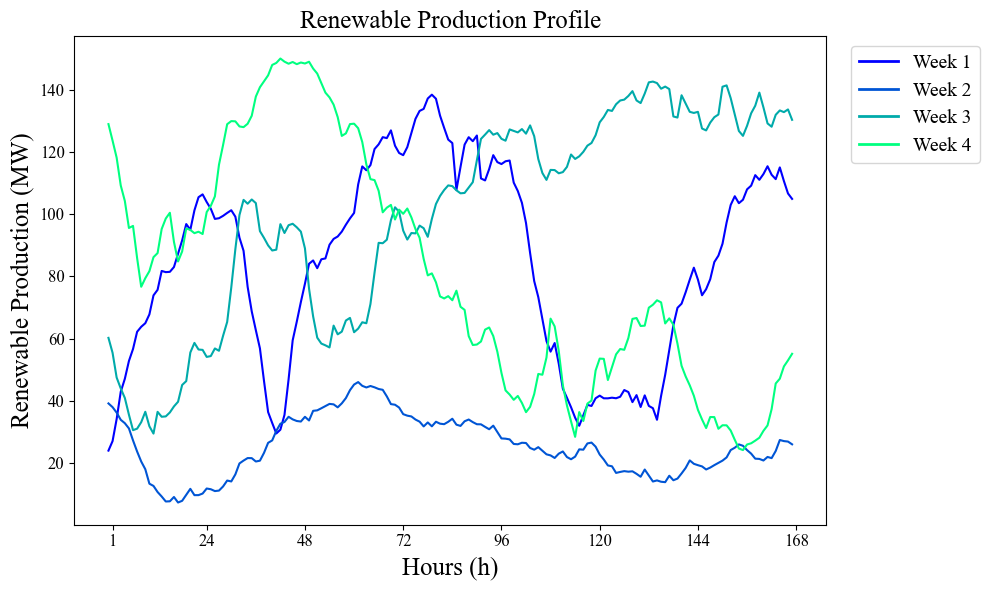

/tmp/ipython-input-1308165297.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('winter', w_dem_data.shape[1])


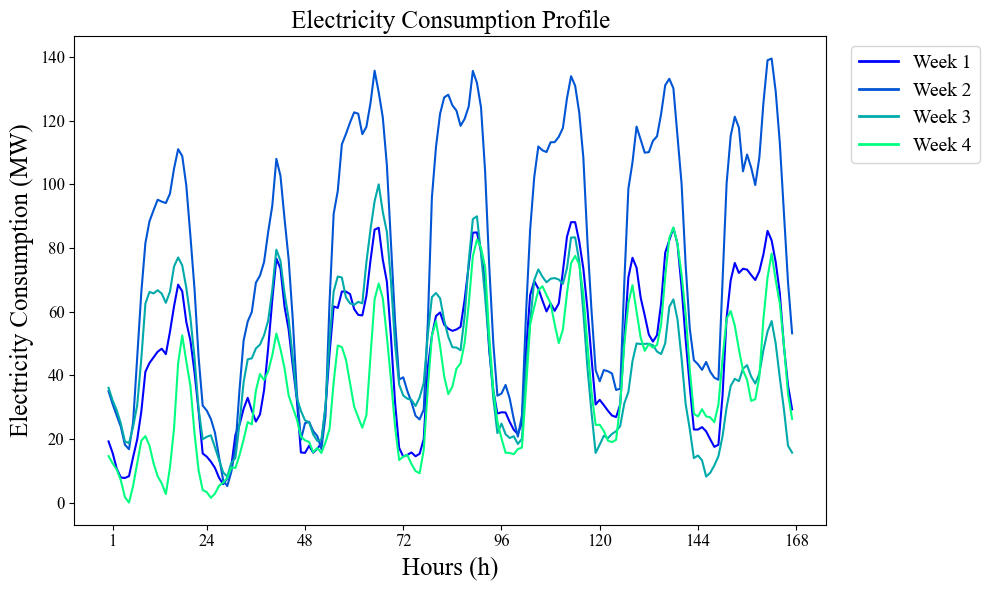

In [ ]:
print('=====================================')
print('           Load Demand Data          ')
print('=====================================')
# Load demand data: each list element contains [pmax] for a bus
data_dem = [[0],[0],[100]]
nn = len(data_dem)   # Number of buses

# Create a DataFrame for load demand with bus labels as index
dem = pd.DataFrame(data_dem,index=['n'+str(i) for i in range(nn)],columns=['pmax'])
print(dem)

print('=====================================')
print('              Line Data              ')
print('=====================================')
# Line data: list of [from_bus, to_bus, max_capacity]
data_lin = [[0,1,100],[0,2,100],[1,0,100]]

# Initialize a zero matrix for line capacities between buses
lin = pd.DataFrame(np.zeros((nn, nn), dtype=int), index=range(nn), columns=range(nn))

# Fill matrix symmetrically with line capacities
for from_bus, to_bus, pmax in data_lin:
    lin[from_bus][to_bus] = pmax
    lin[to_bus][from_bus] = pmax   # Symmetric capacity since undirected line
print(lin)

print('=====================================')
print('       Thermal Power Plant Data      ')
print('=====================================')
# Generator data: [bus, pmin, pmax, operating_cost]
data_gen = [[0,0,250,50]]
ng = len(data_gen)   # Number of thermal generation units

# DataFrame with generator info indexed by generator ID
gen = pd.DataFrame(data_gen,index=['g'+str(i) for i in range(ng)],
                   columns=['bus','pmin','pmax','o_cost'])
print(gen)

print('=====================================')
print('      Sulphur-Flow Battery Data      ')
print('=====================================')
# Battery storage data:
# Columns - bus, initial_energy, min_energy, max_energy, charge_min, charge_max, discharge_min, discharge_max, charge_eff, discharge_eff
data_bat = [[1,100,0,2400,0,100,0,100,0.9,0.9]]
nb = len(data_bat)   # Number of battery storage units

# DataFrame with battery info indexed by battery ID
bat = pd.DataFrame(data_bat,index=['b'+str(i) for i in range(nb)],
                   columns=['bus','eini','emin','emax','pcmin','pcmax','pdmin','pdmax','etac','etad'])
print(bat)

print('=====================================')
print('            Renewable Data           ')
print('=====================================')
# Renewable generation data: [bus, pmin, pmax, operating_cost]
data_ren = [[1,0,150,0]]
nw = len(data_ren)   # Number of renewable source units

# DataFrame with source info indexed by source ID
ren = pd.DataFrame(data_ren,index=['w'+str(i) for i in range(nw)],
                   columns=['bus','pmin','pmax','o_cost'])
print(ren)

print('=====================================')
print(' Hourly Demand and Renewable Profile ')
print('=====================================')
# Load hourly profiles from external CSV (normalized)
h_data = pd.read_csv('https://raw.githubusercontent.com/sanaz-mahmoudi/sanazmahmoudi/refs/heads/main/Hourly%20Profiles.csv')

nd = 28;  # Number of days
nh = 24;  # Number of hours

# Extract normalized electricity consumption profile and reshape
d_profile = h_data['Normalised Electricity Consumption Profile'].values.reshape((nd, nh))

# Initialize 3D array: days x hours x buses for load demand
pld = np.zeros((nd, nh, nn))
for i in range(nn):
    pld[:, :, i] = d_profile * dem['pmax'].values[i]

# Dunkelflaute event during the second week
pld[7:13, :, :] *= 1.4
print('Hourly Load Demand =\n', pld)

# Extract normalized renewable profile and reshape
r_profile = h_data['Normalised Renewable Production Profile'].values.reshape((nd, nh))

# Initialize 3D array: days x hours x renewables for generation
pr = np.zeros((nd, nh, nw))
for i in range(nw):
    pr[:, :, i] = r_profile * ren['pmax'].values[i]

# Dunkelflaute event during the second week
pr[7:13, :, :] *= 0.4
print('Hourly Renewable Generstion =\n', pr)

print('=====================================')
print('     PyPlots for Hourly Profiles     ')
print('=====================================')
# Reshape normalized profiles into weekly blocks (7 days x 24 hours)
re_h_ren_data = h_data['Normalised Renewable Production Profile'].values.reshape(-1, 7*24).T
re_h_dem_data = h_data['Normalised Electricity Consumption Profile'].values.reshape(-1, 7*24).T

# Convert to DataFrames with columns as weeks for plotting convenience
w_ren_data = pd.DataFrame(re_h_ren_data, columns=[f'week{i+1}' for i in range(re_h_ren_data.shape[1])])
w_dem_data = pd.DataFrame(re_h_dem_data, columns=[f'week{i+1}' for i in range(re_h_dem_data.shape[1])])

# Dunkelflaute event during the second week
if 'week1' in w_ren_data.columns:
    w_ren_data['week2'] *= 0.4
    w_dem_data['week2'] *= 1.4

print(w_ren_data)
print(w_dem_data)

# -------------------- Plot 1: Renewable Production --------------------
colors = plt.cm.get_cmap('winter', w_ren_data.shape[1])

plt.figure(figsize=(10, 6))
x = np.arange(len(w_ren_data.index))

# Plot each week's renewable profile scaled by max renewable capacity
for i, week in enumerate(w_ren_data.columns):
    plt.plot(x, w_ren_data[week] * ren['pmax'].values, label=week, color=colors(i))

# Legend setup
legend_lines = [Line2D([0], [0], color=colors(i), lw=2) for i in range(w_ren_data.shape[1])]
legend_labels = [f'Week {i+1}' for i in range(w_ren_data.shape[1])]
plt.legend(legend_lines, legend_labels, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)

# Axis ticks and labels
tick_positions = [1] + [24 * i for i in range(1, 8)]
tick_positions = [t for t in tick_positions if t <= 168]
plt.xticks(tick_positions, [str(t) for t in tick_positions], fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Hours (h)', fontname='Times New Roman', fontsize=18)
plt.ylabel('Renewable Production (MW)', fontname='Times New Roman', fontsize=18)
plt.title('Renewable Production Profile', fontname='Times New Roman', fontsize=18)
plt.tight_layout()
plt.show()

# -------------------- Plot 2: Electricity Consumption --------------------
colors = plt.cm.get_cmap('winter', w_dem_data.shape[1])

plt.figure(figsize=(10, 6))
x = np.arange(len(w_dem_data.index))

# Plot each week's electricity consumption profile scaled by max load demand at bus 2
for i, week in enumerate(w_dem_data.columns):
    plt.plot(x, w_dem_data[week] * dem['pmax'].values[2], label=f'Week {i+1}', color=colors(i))

# Legend setup
legend_lines = [Line2D([0], [0], color=colors(i), lw=2) for i in range(w_dem_data.shape[1])]
legend_labels = [f'Week {i+1}' for i in range(w_dem_data.shape[1])]
plt.legend(legend_lines, legend_labels, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)

# Axis ticks and labels
tick_positions = [1] + [24 * i for i in range(1, 8)]
tick_positions = [t for t in tick_positions if t <= 168]
plt.xticks(tick_positions, [str(t) for t in tick_positions], fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Hours (h)', fontname='Times New Roman', fontsize=18)
plt.ylabel('Electricity Consumption (MW)', fontname='Times New Roman', fontsize=18)
plt.title('Electricity Consumption Profile', fontname='Times New Roman', fontsize=18)
plt.tight_layout()
plt.show()


## Optimization Model

In [ ]:
# Create a ConcreteModel object to build the optimization model
m = pe.ConcreteModel()

# Sets (Indices for various system components)
m.b  = pe.Set(initialize=list(range(nb)))                        # Set of Sulphur-flow batteries
m.g  = pe.Set(initialize=gen.index.tolist())                     # Set of thermal power plants
m.i  = pe.Set(initialize=list(range(nn)))                        # Set of network nodes
m.j  = pe.Set(initialize=list(range(nn)))                        # Set of pair nodes (for power flow)
m.td = pe.Set(initialize=list(range(nd)))                        # Set of time days
m.th = pe.Set(initialize=list(range(nh)))                        # Set of time hours
m.w  = pe.Set(initialize=list(range(nw)))                        # Set of renewable generation sources

# Decision variables
# Battery charging and discharging status
m.bcb = pe.Var(m.b,m.td,m.th,within=pe.Binary)                   # Charging status
m.bdb = pe.Var(m.b,m.td,m.th,within=pe.Binary)                   # Discharging status

# Battery power exchange
m.pcb = pe.Var(m.b,m.td,m.th,within=pe.NonNegativeReals)         # Charging power
m.pdb = pe.Var(m.b,m.td,m.th,within=pe.NonNegativeReals)         # Discharging power

# Demand shedding
m.uld = pe.Var(m.td,m.th,m.i,within=pe.NonNegativeReals)         # Demand shedding

# Thermal generator outputs
m.pg  = pe.Var(m.g,m.td,m.th,within=pe.NonNegativeReals)         # Power generation from thermal plants

# Power flows between nodes
m.pl  = pe.Var(m.i,m.j,m.td,m.th,within=pe.Reals)                # Line power flow between nodes

# Renewable power generation
m.pw  = pe.Var(m.w,m.td,m.th,within=pe.NonNegativeReals)         # Renewable energy production

# Objective: Minimize total cost
def obj_rule(m):
  return (sum(gen['o_cost'][g]*m.pg[g,td,th] for g in m.g for td in m.td for th in m.th) +
          sum(500*m.uld[td,th,i] for td in m.td for th in m.th for i in m.i))
m.obj = pe.Objective(rule=obj_rule)

# Constraints
# Ensure power generation and storage matches demand and flows
def bal_rule(m,i,td,th):
  return (sum(m.pg[g,td,th] for g in m.g if gen['bus'][g] == i) +
          sum(m.pw[w,td,th] for w in m.w if ren['bus'][w] == i) +
          sum(m.pdb[b,td,th] for b in m.b if bat['bus'][b] == i)) == (pld[td,th,i] - m.uld[td,th,i] +
                                                                      sum(m.pl[i,j,td,th] for j in m.j) +
                                                                      sum(m.pcb[b,td,th] for b in m.b if bat['bus'][b] == i))
m.bal = pe.Constraint(m.i, m.td, m.th, rule=bal_rule)

# -------------- Thermal Generation Constraints ----------------
# Thermal min generation limit
def min_gen_rule(m,g,td,th):
    return m.pg[g,td,th] >= gen['pmin'][g]
m.min_gen = pe.Constraint(m.g, m.td, m.th, rule=min_gen_rule)

# Thermal max generation limit
def max_gen_rule(m,g,td,th):
    return m.pg[g,td,th] <= gen['pmax'][g]
m.max_gen = pe.Constraint(m.g, m.td,  m.th, rule=max_gen_rule)

# -------------- Renewable Generation Constraint ---------------
# Renewable output limited by available profile
def max_ren_rule(m,w,td,th):
    return m.pw[w,td,th] <= pr[td,th,w]
m.max_ren = pe.Constraint(m.w, m.td, m.th, rule=max_ren_rule)

# ------------- Load Demand Shedding Constraint ---------------
# Load demand shedding limited by available profile
def ld_shed_rule(m,td,th,i):
    return m.uld[td,th,i] <= pld[td,th,i]
m.ld_shed = pe.Constraint(m.td, m.th, m.i, rule=ld_shed_rule)

# --------- Sulphur-Flow Battery Operation Constraints ---------
# Minimum charging limit
def min_cha_rule(m,b,td,th):
    return m.pcb[b,td,th] >= bat['pcmin'][b]*m.bcb[b,td,th]
m.min_cha = pe.Constraint(m.b, m.td, m.th, rule=min_cha_rule)

# Maximum charging limit
def max_cha_rule(m,b,td,th):
    return m.pcb[b,td,th] <= bat['pcmax'][b]*m.bcb[b,td,th]
m.max_cha = pe.Constraint(m.b, m.td, m.th, rule=max_cha_rule)

# Minimum discharging limit
def min_dis_rule(m,b,td,th):
    return m.pdb[b,td,th] >= bat['pdmin'][b]*m.bdb[b,td,th]
m.min_dis = pe.Constraint(m.b, m.td, m.th, rule=min_dis_rule)

# Maximum discharging limit
def max_dis_rule(m,b,td,th):
    return m.pdb[b,td,th] <= bat['pdmax'][b]*m.bdb[b,td,th]
m.max_dis = pe.Constraint(m.b, m.td, m.th, rule=max_dis_rule)

# Minimum stored energy range
def min_sto_rule(m,b,td):
    return bat['emin'][b] <= (bat['eini'][b] +
                              sum(bat['etac'][b]*m.pcb[b,td,th] - (1/bat['etad'][b])*m.pdb[b,td,th] for th in m.th))
m.min_sto = pe.Constraint(m.b, m.td, rule=min_sto_rule)

# Maximum stored energy range
def max_sto_rule(m,b,td):
    return bat['eini'][b] + sum(bat['etac'][b]*m.pcb[b,td,th] - (1/bat['etad'][b])*m.pdb[b,td,th] for th in m.th) <= bat['emax'][b]
m.max_sto = pe.Constraint(m.b, m.td, rule=max_sto_rule)

# Initial-final SOC balance (cyclic operation)
def bid_sto_rule(m,b,td):
    return sum(bat['etac'][b]*m.pcb[b,td,th] - (1/bat['etad'][b])*m.pdb[b,td,th] for th in m.th) == 0
m.bid_sto = pe.Constraint(m.b, m.td, rule=bid_sto_rule)

# Prevent simultaneous charging/discharging
def cha_dis_rule(m,b,td,th):
    return m.bcb[b,td,th] + m.bdb[b,td,th] <= 1
m.cha_dis = pe.Constraint(m.b, m.td, m.th, rule=cha_dis_rule)

# ------------- Power Flow Constraints (Lines) ---------------
# Line flow lower bound
def min_flow_rule(m,i,j,td,th):
    return m.pl[i,j,td,th] >= -lin.loc[i,j]
m.min_flow = pe.Constraint(m.i, m.j, m.td, m.th, rule=min_flow_rule)

# Line flow upper bound
def max_flow_rule(m,i,j,td,th):
    return m.pl[i,j,td,th] <= lin.loc[i,j]
m.max_flow = pe.Constraint(m.i, m.j, m.td, m.th, rule=max_flow_rule)

# Line flow symmetry (Kirchhoff’s law)
def adj_flow_rule(m,i,j,td,th):
    return m.pl[i,j,td,th] == -m.pl[j,i,td,th]
m.adj_flow = pe.Constraint(m.i,m.j,m.td,m.th,rule=adj_flow_rule)

# Solve using GLPK with a relative gap of 1e-5
solver.options['mipgap'] = 1e-5
solver.solve(m,tee=True).write()


/tmp/ipython-input-1149716134.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(m.pw[w,td,th] for w in m.w if ren['bus'][w] == i) +
/tmp/ipython-input-1149716134.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(m.pdb[b,td,th] for b in m.b if bat['bus'][b] == i)) == (pld[td,th,i] - m.uld[td,th,i] +
/tmp/ipython-input-1149716134.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(m.pcb[b,td,th] for b in m.b if bat[

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --mipgap 1e-05 --write /tmp/tmpml6rgh6z.glpk.raw --wglp /tmp/tmp6l0nwk9m.glpk.glp
 --cpxlp /tmp/tmpsinb_lmn.pyomo.lp
Reading problem data from '/tmp/tmpsinb_lmn.pyomo.lp'...
/tmp/tmpsinb_lmn.pyomo.lp:144070: warning: lower bound of variable 'x17475' redefined
/tmp/tmpsinb_lmn.pyomo.lp:144070: warning: upper bound of variable 'x17475' redefined
27636 rows, 12096 columns, 46368 non-zeros
1344 integer variables, all of which are binary
145414 lines were read
Writing problem data to '/tmp/tmp6l0nwk9m.glpk.glp'...
119758 lines were written
GLPK Integer Optimizer 5.0
27636 rows, 12096 columns, 46368 non-zeros
1344 integer variables, all of which are binary
Preprocessing...
6101 rows, 5374 columns, 15450 non-zeros
1344 integer variables, all of which are binary
Scaling...
 A: min|aij| =  9.000e-01  max|aij| =  1.000e+02  ratio =  1.111e+02
GM: min|aij| =  7.551e-01  max|aij| =  1.324e+00  ratio =  1.754e+00
EQ: min|ai

## Print Results

In [ ]:
# Display the optimal value of the objective function
print('Optimal Value =',m.obj())

# --------------- Thermal Generation Results -----------------
# Extract and organize power output from thermal units
data = []
for (g, td, th) in m.pg:
            value = m.pg[g,td,th].value
            data.append({
                'g':g,
                'td': td,
                'th': th,
                'value': value
                })

df = pd.DataFrame(data)
df = df.sort_values(by=['g', 'td', 'th'])
thermal = df['g'].unique()

# Display hourly thermal generation for each unit
for g in thermal:
    sub_df = df[df['g'] == g]
    pivot = sub_df.pivot(index='td', columns='th', values='value')
    print(f"\nThermal Generation: {g}")
    display(pivot)

# ------------- Renewable Generation Results ----------------
# Extract and organize power output from renewable sources
data = []
for (w, td, th) in m.pw:
            value = m.pw[w,td,th].value
            data.append({
                'w':w,
                'td': td,
                'th': th,
                'value': value
                })

df = pd.DataFrame(data)
df = df.sort_values(by=['w', 'td', 'th'])
renewable = df['w'].unique()

# Display hourly renewable generation for each source
for w in renewable:
    sub_df = df[df['w'] == w]
    pivot = sub_df.pivot(index='td', columns='th', values='value')
    print(f"\nRenewable Generation: {w}")
    display(pivot)

# ------------- Load Demand Shedding Results ----------------
# Extract and organize load shedding
data = []
for (td, th, i) in m.uld:
            value = m.uld[td,th,i].value
            data.append({
                'i':i,
                'td': td,
                'th': th,
                'value': value
                })

df = pd.DataFrame(data)
df = df.sort_values(by=['i', 'td', 'th'])
shedding = df['i'].unique()

# Display hourly load demand shedding for each bus
for n in shedding:
    sub_df = df[df['i'] == i]
    pivot = sub_df.pivot(index='td', columns='th', values='value')
    print(f"\nDemand Shedding: {i}")
    display(pivot)

# --------------- Battery Charging Results -----------------
# Extract charging power for each battery
data = []
for (b, td, th) in m.pcb:
            value = m.pcb[b,td,th].value
            data.append({
                'b':b,
                'td': td,
                'th': th,
                'value': value
                })

df = pd.DataFrame(data)
df = df.sort_values(by=['b', 'td', 'th'])
batteries = df['b'].unique()

# Display hourly charging profiles
for b in batteries:
    sub_df = df[df['b'] == b]
    pivot = sub_df.pivot(index='td', columns='th', values='value')
    print(f"\nCharging Batteries: {b}")
    display(pivot)

# -------------- Battery Disharging Results ---------------
# Extract discharging power for each battery
data = []
for (b, td, th) in m.pdb:
            value = m.pdb[b,td,th].value
            data.append({
                'b':b,
                'td': td,
                'th': th,
                'value': value
                })

df = pd.DataFrame(data)
df = df.sort_values(by=['b', 'td', 'th'])
batteries = df['b'].unique()

# Display hourly discharging profiles
for b in batteries:
    sub_df = df[df['b'] == b]
    pivot = sub_df.pivot(index='td', columns='th', values='value')
    print(f"\nDischarging Batteries: {b}")
    display(pivot)

# ----------- Power Flow Between Nodes (Lines) ------------
# Extract line flows between all node pairs
data = []
for (i, j, td, th) in m.pl:
    value = m.pl[i,j,td,th].value
    data.append({
        'i': i,
        'j': j,
        'td': td,
        'th': th,
        'value': value
        })

df = pd.DataFrame(data)
df = df.sort_values(by=['i', 'j', 'td', 'th'])

# Create a unique label for each directional line
df['group'] = df['i'].astype(str) + ' → ' + df['j'].astype(str)

# Pivot each group (line) and display
pivoted_tables = {}
groups = df['group'].unique()

for group in groups:
    sub_df = df[df['group'] == group]
    pivot = sub_df.pivot(index='td', columns='th', values='value')
    pivoted_tables[group] = pivot

for group, table in pivoted_tables.items():
    print(f"\n=== {group} ===")
    display(table)


Optimal Value = 867901.4211752703

Thermal Generation: g0


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,37.318039,31.927923,...,0.000000e+00,0.000000,30.120764,25.903960,0.000000,1.108800e+00,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.163736e+01,0.000000,63.468379,...,8.643556e+01,89.307754,90.856149,92.639006,92.087453,8.973499e+01,72.017236,57.432291,35.921966,15.815690
8,0.000000,14.622920,1.326850,3.056797,0.000000,0.000000,0.000000,1.143580e+00,15.574522,30.093871,...,5.229877e+01,58.503227,65.955896,69.622857,67.327205,5.591798e+01,41.532046,23.664425,1.003491,0.000000



Renewable Generation: 0


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,19.199484,15.553450,10.650177,7.848147,7.711271,8.291220,14.255931,19.825680,28.549904,41.114472,...,46.632752,53.646220,61.698374,68.475387,66.386451,56.736547,50.900133,41.001839,28.783375,15.406878
1,103.893168,72.684154,10.877308,7.784371,5.772638,7.599757,11.534832,21.348838,24.464526,29.481179,...,35.339970,36.417391,32.906832,29.537888,30.767702,35.522981,46.911801,43.009842,32.397334,71.761491
2,15.605291,17.839680,15.662727,16.920340,18.584104,29.854136,46.979976,61.651755,61.167656,66.327524,...,58.817650,65.018443,76.151973,85.767565,86.366535,76.339943,69.414494,52.011174,31.406386,17.143369
3,14.446139,14.974993,15.736200,14.539379,15.315876,19.932346,42.442947,52.403525,58.634901,59.729904,...,55.226814,63.760830,74.556460,84.810556,84.906033,79.036427,69.532348,47.854934,35.220996,27.959885
4,116.101863,116.996273,117.234783,110.131677,21.537555,54.548037,47.792277,65.236250,69.605075,67.222249,...,51.972671,43.908075,41.016149,37.975155,34.613665,32.019876,35.351553,38.727950,38.377640,30.804432
5,41.701863,40.844721,40.837267,41.038509,40.859627,41.336646,43.498137,42.857143,39.614907,41.865839,...,33.942857,41.634783,48.417391,56.467081,64.315528,69.905590,71.239752,74.921739,78.954037,82.807453
6,22.925703,23.705557,22.365148,19.877521,17.490219,18.173478,33.514342,58.120965,69.872859,75.300883,...,69.937008,72.712558,78.048835,85.391624,82.392672,75.531744,65.804637,49.080473,36.798980,29.287614
7,39.199006,38.006460,36.244472,33.936894,32.845714,31.167205,27.315279,23.746584,20.541615,18.058137,...,7.694907,7.754534,9.143851,7.360994,7.912547,9.853416,11.755528,9.731180,9.737143,10.243975
8,11.862857,11.630311,11.037019,11.195031,12.521739,14.420870,14.128696,16.403478,19.918509,20.836770,...,23.320248,26.534161,27.318261,30.377143,32.672795,33.242236,34.908820,34.077019,33.552298,33.379379



Demand Shedding: 2


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,3.552714e-15,-3.552714e-15,-0.000000e+00,-7.105427e-15,8.881784e-16,1.776357e-15,-3.552714e-15,-0.000000e+00,3.552714e-15,-1.421085e-14,...,-1.421085e-14,-0.000000e+00,-7.105427e-15,-0.000000e+00,-1.421085e-14,-7.105427e-15,-7.105427e-15,-7.105427e-15,-7.105427e-15,-1.776357e-15
1,-5.329071e-15,5.329071e-15,5.329071e-15,-5.329071e-15,4.440892e-15,5.329071e-15,1.776357e-15,-3.552714e-15,-0.000000e+00,1.421085e-14,...,7.105427e-15,7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-7.105427e-15,7.105427e-15,-0.000000e+00,7.105427e-15,-0.000000e+00
2,5.329071e-15,7.105427e-15,-1.776357e-15,3.552714e-15,3.552714e-15,7.105427e-15,-0.000000e+00,-7.105427e-15,1.421085e-14,-1.421085e-14,...,7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,7.105427e-15,-1.065814e-14,-3.552714e-15
3,-0.000000e+00,-0.000000e+00,-5.329071e-15,-0.000000e+00,-7.105427e-15,3.552714e-15,7.105427e-15,1.421085e-14,1.421085e-14,-0.000000e+00,...,1.421085e-14,-1.421085e-14,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,7.105427e-15,-1.421085e-14,-3.552714e-15
4,7.105427e-15,7.105427e-15,7.105427e-15,-7.105427e-15,3.552714e-15,-3.552714e-15,-7.105427e-15,1.421085e-14,1.421085e-14,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-0.000000e+00,-1.065814e-14
5,7.105427e-15,-1.421085e-14,-7.105427e-15,-7.105427e-15,-7.105427e-15,3.552714e-15,-1.421085e-14,-0.000000e+00,-0.000000e+00,-0.000000e+00,...,-1.421085e-14,-7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-0.000000e+00,-7.105427e-15
6,7.105427e-15,-3.552714e-15,3.552714e-15,-3.552714e-15,3.552714e-15,7.105427e-15,7.105427e-15,-7.105427e-15,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,1.421085e-14,-7.105427e-15,-0.000000e+00,-1.065814e-14
7,-0.000000e+00,-7.105427e-15,3.552714e-15,3.552714e-15,3.552714e-15,-3.552714e-15,3.552714e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,4.945567e+00,1.105409e+01,8.918013e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-1.421085e-14,-1.421085e-14
8,-3.552714e-15,3.552714e-15,3.552714e-15,7.105427e-15,-5.329071e-15,8.881784e-16,-5.329071e-15,-3.552714e-15,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,8.004789e+00,2.680521e+00,-0.000000e+00,-0.000000e+00,7.105427e-15,-7.105427e-15,-7.105427e-15



Demand Shedding: 2


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,3.552714e-15,-3.552714e-15,-0.000000e+00,-7.105427e-15,8.881784e-16,1.776357e-15,-3.552714e-15,-0.000000e+00,3.552714e-15,-1.421085e-14,...,-1.421085e-14,-0.000000e+00,-7.105427e-15,-0.000000e+00,-1.421085e-14,-7.105427e-15,-7.105427e-15,-7.105427e-15,-7.105427e-15,-1.776357e-15
1,-5.329071e-15,5.329071e-15,5.329071e-15,-5.329071e-15,4.440892e-15,5.329071e-15,1.776357e-15,-3.552714e-15,-0.000000e+00,1.421085e-14,...,7.105427e-15,7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-7.105427e-15,7.105427e-15,-0.000000e+00,7.105427e-15,-0.000000e+00
2,5.329071e-15,7.105427e-15,-1.776357e-15,3.552714e-15,3.552714e-15,7.105427e-15,-0.000000e+00,-7.105427e-15,1.421085e-14,-1.421085e-14,...,7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,7.105427e-15,-1.065814e-14,-3.552714e-15
3,-0.000000e+00,-0.000000e+00,-5.329071e-15,-0.000000e+00,-7.105427e-15,3.552714e-15,7.105427e-15,1.421085e-14,1.421085e-14,-0.000000e+00,...,1.421085e-14,-1.421085e-14,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,7.105427e-15,-1.421085e-14,-3.552714e-15
4,7.105427e-15,7.105427e-15,7.105427e-15,-7.105427e-15,3.552714e-15,-3.552714e-15,-7.105427e-15,1.421085e-14,1.421085e-14,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-0.000000e+00,-1.065814e-14
5,7.105427e-15,-1.421085e-14,-7.105427e-15,-7.105427e-15,-7.105427e-15,3.552714e-15,-1.421085e-14,-0.000000e+00,-0.000000e+00,-0.000000e+00,...,-1.421085e-14,-7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-0.000000e+00,-7.105427e-15
6,7.105427e-15,-3.552714e-15,3.552714e-15,-3.552714e-15,3.552714e-15,7.105427e-15,7.105427e-15,-7.105427e-15,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,1.421085e-14,-7.105427e-15,-0.000000e+00,-1.065814e-14
7,-0.000000e+00,-7.105427e-15,3.552714e-15,3.552714e-15,3.552714e-15,-3.552714e-15,3.552714e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,4.945567e+00,1.105409e+01,8.918013e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-1.421085e-14,-1.421085e-14
8,-3.552714e-15,3.552714e-15,3.552714e-15,7.105427e-15,-5.329071e-15,8.881784e-16,-5.329071e-15,-3.552714e-15,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,8.004789e+00,2.680521e+00,-0.000000e+00,-0.000000e+00,7.105427e-15,-7.105427e-15,-7.105427e-15



Demand Shedding: 2


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,3.552714e-15,-3.552714e-15,-0.000000e+00,-7.105427e-15,8.881784e-16,1.776357e-15,-3.552714e-15,-0.000000e+00,3.552714e-15,-1.421085e-14,...,-1.421085e-14,-0.000000e+00,-7.105427e-15,-0.000000e+00,-1.421085e-14,-7.105427e-15,-7.105427e-15,-7.105427e-15,-7.105427e-15,-1.776357e-15
1,-5.329071e-15,5.329071e-15,5.329071e-15,-5.329071e-15,4.440892e-15,5.329071e-15,1.776357e-15,-3.552714e-15,-0.000000e+00,1.421085e-14,...,7.105427e-15,7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-7.105427e-15,7.105427e-15,-0.000000e+00,7.105427e-15,-0.000000e+00
2,5.329071e-15,7.105427e-15,-1.776357e-15,3.552714e-15,3.552714e-15,7.105427e-15,-0.000000e+00,-7.105427e-15,1.421085e-14,-1.421085e-14,...,7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,7.105427e-15,-1.065814e-14,-3.552714e-15
3,-0.000000e+00,-0.000000e+00,-5.329071e-15,-0.000000e+00,-7.105427e-15,3.552714e-15,7.105427e-15,1.421085e-14,1.421085e-14,-0.000000e+00,...,1.421085e-14,-1.421085e-14,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,7.105427e-15,-1.421085e-14,-3.552714e-15
4,7.105427e-15,7.105427e-15,7.105427e-15,-7.105427e-15,3.552714e-15,-3.552714e-15,-7.105427e-15,1.421085e-14,1.421085e-14,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-0.000000e+00,-1.065814e-14
5,7.105427e-15,-1.421085e-14,-7.105427e-15,-7.105427e-15,-7.105427e-15,3.552714e-15,-1.421085e-14,-0.000000e+00,-0.000000e+00,-0.000000e+00,...,-1.421085e-14,-7.105427e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-0.000000e+00,-7.105427e-15
6,7.105427e-15,-3.552714e-15,3.552714e-15,-3.552714e-15,3.552714e-15,7.105427e-15,7.105427e-15,-7.105427e-15,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,1.421085e-14,-7.105427e-15,-0.000000e+00,-1.065814e-14
7,-0.000000e+00,-7.105427e-15,3.552714e-15,3.552714e-15,3.552714e-15,-3.552714e-15,3.552714e-15,-0.000000e+00,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,4.945567e+00,1.105409e+01,8.918013e+00,-0.000000e+00,-0.000000e+00,-1.421085e-14,-1.421085e-14,-1.421085e-14
8,-3.552714e-15,3.552714e-15,3.552714e-15,7.105427e-15,-5.329071e-15,8.881784e-16,-5.329071e-15,-3.552714e-15,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,8.004789e+00,2.680521e+00,-0.000000e+00,-0.000000e+00,7.105427e-15,-7.105427e-15,-7.105427e-15



Charging Batteries: 0


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,89.482086,59.834273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,56.027902
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,87.738811,88.707440,91.888212,87.260053,0.000000,29.437548,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5,9.425740,10.230497,11.974079,13.697361,14.000341,10.562423,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,3.602774,23.821701,42.344147,59.854151
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,4.217673,7.065972,8.943305,10.130937,14.678353,14.411190,2.128782,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,5.494770,9.252199,4.454996,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,13.641419



Discharging Batteries: 0


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.216295e+01,3.081036e+01,4.712429e+01,4.275529e+01,2.602994e+01,7.446022e+00,0.000000e+00,0.000000,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,1.060215e+01,2.874444e+01,4.252747e+01,5.014913e+01,5.349533e+01,4.998044e+01,3.816212e+01,2.203318e+01,6.955355,0.000000
5,0.000000,0.0,0.000000,0.0,0.0,0.0,8.166187,2.791939e+01,0.000000e+00,0.000000e+00,...,1.865983e+01,2.097025e+01,0.000000e+00,0.000000e+00,2.198052e+01,1.026053e+01,0.000000e+00,0.000000e+00,0.000000,0.000000
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,4.546323e+01,0.000000e+00,...,0.000000e+00,5.329071e-15,-5.329071e-15,2.664535e-15,-4.440892e-15,5.329071e-15,-5.329071e-15,3.552714e-15,0.000000,4.413506
8,17.016741,0.0,9.586401,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000



=== 0 → 0 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



=== 0 → 1 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,-19.199484,-15.553450,-10.650177,-7.848147,-7.711271,-8.291220,-14.255931,-19.825680,-28.549904,-41.114472,...,-46.632752,-53.646220,-61.698374,-68.475387,-66.386451,-56.736547,-50.900133,-41.001839,-28.783375,-15.406878
1,-14.411081,-12.849881,-10.877308,-7.784371,-5.772638,-7.599757,-11.534832,-21.348838,-24.464526,-29.481179,...,-35.339970,-48.580337,-63.717194,-76.662179,-73.522995,-61.552921,-54.357823,-43.009842,-32.397334,-15.733589
2,-15.605291,-17.839680,-15.662727,-16.920340,-18.584104,-29.854136,-46.979976,-61.651755,-61.167656,-66.327524,...,-58.817650,-65.018443,-76.151973,-85.767565,-86.366535,-76.339943,-69.414494,-52.011174,-31.406386,-17.143369
3,-14.446139,-14.974993,-15.736200,-14.539379,-15.315876,-19.932346,-42.442947,-52.403525,-58.634901,-59.729904,...,-55.226814,-63.760830,-74.556460,-84.810556,-84.906033,-79.036427,-69.532348,-47.854934,-35.220996,-27.959885
4,-28.363052,-28.288833,-25.346571,-22.871624,-21.537555,-25.110489,-47.792277,-65.236250,-69.605075,-67.222249,...,-62.574825,-72.652512,-83.543619,-88.124284,-88.108993,-82.000321,-73.513671,-60.761132,-45.332995,-30.804432
5,-32.276123,-30.614224,-28.863188,-27.341148,-26.859287,-30.774223,-51.664323,-70.776535,-39.614907,-41.865839,...,-52.602685,-62.605034,-48.417391,-56.467081,-86.296046,-80.166119,-67.636978,-51.100038,-36.609890,-22.953302
6,-22.925703,-23.705557,-22.365148,-19.877521,-17.490219,-18.173478,-33.514342,-58.120965,-69.872859,-75.300883,...,-69.937008,-72.712558,-78.048835,-85.391624,-82.392672,-75.531744,-65.804637,-49.080473,-36.798980,-29.287614
7,-34.981334,-30.940487,-27.301167,-23.805958,-18.167361,-16.756015,-25.186497,-23.746584,-66.004841,-18.058137,...,-7.694907,-7.754534,-9.143851,-7.360994,-7.912547,-9.853416,-11.755528,-9.731180,-9.737143,-14.657481
8,-28.879598,-11.630311,-20.623420,-11.195031,-7.026969,-5.168670,-9.673699,-16.403478,-19.918509,-20.836770,...,-23.320248,-26.534161,-27.318261,-30.377143,-32.672795,-33.242236,-34.908820,-34.077019,-33.552298,-19.737960



=== 0 → 2 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,19.199484,15.553450,10.650177,7.848147,7.711271,8.291220,14.255931,19.825680,28.549904,41.114472,...,46.632752,53.646220,61.698374,68.475387,66.386451,56.736547,50.900133,41.001839,28.783375,15.406878
1,14.411081,12.849881,10.877308,7.784371,5.772638,7.599757,11.534832,21.348838,24.464526,29.481179,...,35.339970,48.580337,63.717194,76.662179,73.522995,61.552921,54.357823,43.009842,32.397334,15.733589
2,15.605291,17.839680,15.662727,16.920340,18.584104,29.854136,46.979976,61.651755,61.167656,66.327524,...,58.817650,65.018443,76.151973,85.767565,86.366535,76.339943,69.414494,52.011174,31.406386,17.143369
3,14.446139,14.974993,15.736200,14.539379,15.315876,19.932346,42.442947,52.403525,58.634901,59.729904,...,55.226814,63.760830,74.556460,84.810556,84.906033,79.036427,69.532348,47.854934,35.220996,27.959885
4,28.363052,28.288833,25.346571,22.871624,21.537555,25.110489,47.792277,65.236250,69.605075,67.222249,...,62.574825,72.652512,83.543619,88.124284,88.108993,82.000321,73.513671,60.761132,45.332995,30.804432
5,32.276123,30.614224,28.863188,27.341148,26.859287,30.774223,51.664323,70.776535,76.932946,73.793762,...,52.602685,62.605034,78.538155,82.371041,86.296046,81.274918,67.636978,51.100038,36.609890,22.953302
6,22.925703,23.705557,22.365148,19.877521,17.490219,18.173478,33.514342,58.120965,69.872859,75.300883,...,69.937008,72.712558,78.048835,85.391624,82.392672,75.531744,65.804637,49.080473,36.798980,29.287614
7,34.981334,30.940487,27.301167,23.805958,18.167361,16.756015,25.186497,45.383941,66.004841,81.526515,...,94.130468,97.062288,100.000000,100.000000,100.000000,99.588404,83.772764,67.163471,45.659109,30.473171
8,28.879598,26.253231,21.950270,14.251828,7.026969,5.168670,9.673699,17.547058,35.493031,50.930641,...,75.619016,85.037389,93.274157,100.000000,100.000000,89.160211,76.440866,57.741443,34.555789,19.737960



=== 1 → 0 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,19.199484,15.553450,10.650177,7.848147,7.711271,8.291220,14.255931,19.825680,28.549904,41.114472,...,46.632752,53.646220,61.698374,68.475387,66.386451,56.736547,50.900133,41.001839,28.783375,15.406878
1,14.411081,12.849881,10.877308,7.784371,5.772638,7.599757,11.534832,21.348838,24.464526,29.481179,...,35.339970,48.580337,63.717194,76.662179,73.522995,61.552921,54.357823,43.009842,32.397334,15.733589
2,15.605291,17.839680,15.662727,16.920340,18.584104,29.854136,46.979976,61.651755,61.167656,66.327524,...,58.817650,65.018443,76.151973,85.767565,86.366535,76.339943,69.414494,52.011174,31.406386,17.143369
3,14.446139,14.974993,15.736200,14.539379,15.315876,19.932346,42.442947,52.403525,58.634901,59.729904,...,55.226814,63.760830,74.556460,84.810556,84.906033,79.036427,69.532348,47.854934,35.220996,27.959885
4,28.363052,28.288833,25.346571,22.871624,21.537555,25.110489,47.792277,65.236250,69.605075,67.222249,...,62.574825,72.652512,83.543619,88.124284,88.108993,82.000321,73.513671,60.761132,45.332995,30.804432
5,32.276123,30.614224,28.863188,27.341148,26.859287,30.774223,51.664323,70.776535,39.614907,41.865839,...,52.602685,62.605034,48.417391,56.467081,86.296046,80.166119,67.636978,51.100038,36.609890,22.953302
6,22.925703,23.705557,22.365148,19.877521,17.490219,18.173478,33.514342,58.120965,69.872859,75.300883,...,69.937008,72.712558,78.048835,85.391624,82.392672,75.531744,65.804637,49.080473,36.798980,29.287614
7,34.981334,30.940487,27.301167,23.805958,18.167361,16.756015,25.186497,23.746584,66.004841,18.058137,...,7.694907,7.754534,9.143851,7.360994,7.912547,9.853416,11.755528,9.731180,9.737143,14.657481
8,28.879598,11.630311,20.623420,11.195031,7.026969,5.168670,9.673699,16.403478,19.918509,20.836770,...,23.320248,26.534161,27.318261,30.377143,32.672795,33.242236,34.908820,34.077019,33.552298,19.737960



=== 1 → 1 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



=== 1 → 2 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



=== 2 → 0 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,-19.199484,-15.553450,-10.650177,-7.848147,-7.711271,-8.291220,-14.255931,-19.825680,-28.549904,-41.114472,...,-46.632752,-53.646220,-61.698374,-68.475387,-66.386451,-56.736547,-50.900133,-41.001839,-28.783375,-15.406878
1,-14.411081,-12.849881,-10.877308,-7.784371,-5.772638,-7.599757,-11.534832,-21.348838,-24.464526,-29.481179,...,-35.339970,-48.580337,-63.717194,-76.662179,-73.522995,-61.552921,-54.357823,-43.009842,-32.397334,-15.733589
2,-15.605291,-17.839680,-15.662727,-16.920340,-18.584104,-29.854136,-46.979976,-61.651755,-61.167656,-66.327524,...,-58.817650,-65.018443,-76.151973,-85.767565,-86.366535,-76.339943,-69.414494,-52.011174,-31.406386,-17.143369
3,-14.446139,-14.974993,-15.736200,-14.539379,-15.315876,-19.932346,-42.442947,-52.403525,-58.634901,-59.729904,...,-55.226814,-63.760830,-74.556460,-84.810556,-84.906033,-79.036427,-69.532348,-47.854934,-35.220996,-27.959885
4,-28.363052,-28.288833,-25.346571,-22.871624,-21.537555,-25.110489,-47.792277,-65.236250,-69.605075,-67.222249,...,-62.574825,-72.652512,-83.543619,-88.124284,-88.108993,-82.000321,-73.513671,-60.761132,-45.332995,-30.804432
5,-32.276123,-30.614224,-28.863188,-27.341148,-26.859287,-30.774223,-51.664323,-70.776535,-76.932946,-73.793762,...,-52.602685,-62.605034,-78.538155,-82.371041,-86.296046,-81.274918,-67.636978,-51.100038,-36.609890,-22.953302
6,-22.925703,-23.705557,-22.365148,-19.877521,-17.490219,-18.173478,-33.514342,-58.120965,-69.872859,-75.300883,...,-69.937008,-72.712558,-78.048835,-85.391624,-82.392672,-75.531744,-65.804637,-49.080473,-36.798980,-29.287614
7,-34.981334,-30.940487,-27.301167,-23.805958,-18.167361,-16.756015,-25.186497,-45.383941,-66.004841,-81.526515,...,-94.130468,-97.062288,-100.000000,-100.000000,-100.000000,-99.588404,-83.772764,-67.163471,-45.659109,-30.473171
8,-28.879598,-26.253231,-21.950270,-14.251828,-7.026969,-5.168670,-9.673699,-17.547058,-35.493031,-50.930641,...,-75.619016,-85.037389,-93.274157,-100.000000,-100.000000,-89.160211,-76.440866,-57.741443,-34.555789,-19.737960



=== 2 → 1 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



=== 2 → 2 ===


th,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
td,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Day 8: Total Load Shedding = 24.9177
Day 9: Total Load Shedding = 10.6853
Day 10: Total Load Shedding = 243.9501
Day 11: Total Load Shedding = 296.9217
Day 12: Total Load Shedding = 217.1114
Day 13: Total Load Shedding = 219.9138
Day 14: Total Load Shedding = 0.0000
Day 8: Operational Cost = 56561.36
Day 9: Operational Cost = 33712.84
Day 10: Operational Cost = 40505.87
Day 11: Operational Cost = 50604.66
Day 12: Operational Cost = 60758.59
Day 13: Operational Cost = 73077.50
Day 14: Operational Cost = 10636.95


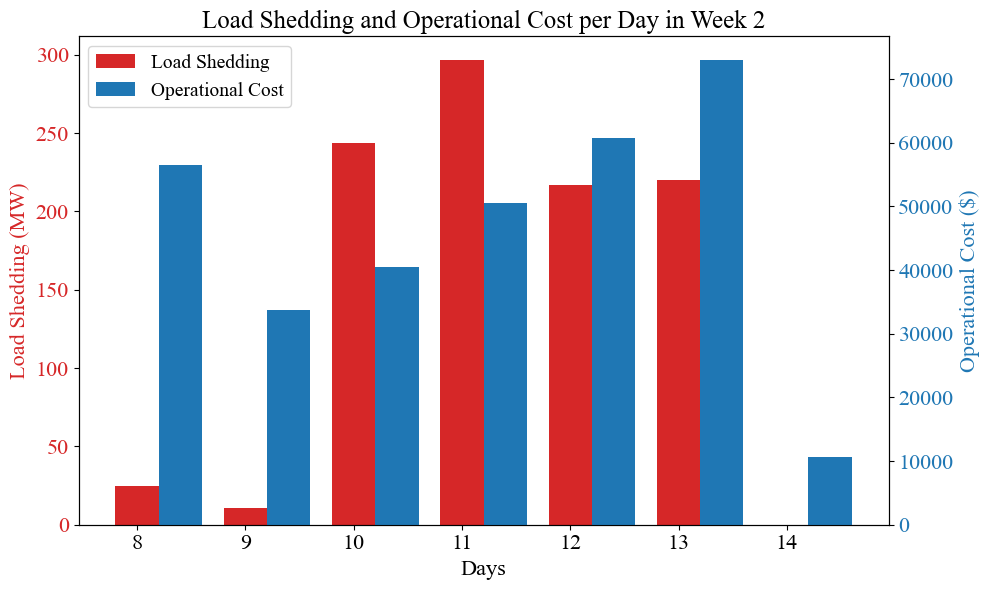

In [ ]:
td_list = list(m.td)  # List of day keys
th_list = list(m.th)  # List of hour keys
week2_day_keys = td_list[7:14]

# For node 2, print the load shedding at the max net load time
daily_uld_bus2 = {}

for td in week2_day_keys:
    total_uld = sum(m.uld[td, th, 2].value for th in th_list)
    daily_uld_bus2[td] = total_uld
    print(f"Day {td+1}: Total Load Shedding = {total_uld:.4f}")

# For each generator g in the model, print the generation at the max net load time
week2_daily_cost = {}

for td in week2_day_keys:
    total_cost = 0
    for g in m.g:
        for th in m.th:
            unit_cost = gen['o_cost'][g]
            pg_val = m.pg[g, td, th].value
            total_cost += unit_cost * pg_val
    week2_daily_cost[td] = total_cost
    print(f"Day {td+1}: Operational Cost = {total_cost:.2f}")

# Convert dictionaries to sorted lists
days = [td + 1 for td in week2_day_keys]  # For labeling (Day 8–14 if indexing from 0)
load_shedding_vals = [daily_uld_bus2[td] for td in week2_day_keys]
op_cost_vals = [week2_daily_cost[td] for td in week2_day_keys]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Load Shedding (left axis)
color1 = 'tab:red'
ax1.set_xlabel('Days', fontsize=16)
ax1.set_ylabel('Load Shedding (MW)', color=color1, fontsize=16)
bar1 = ax1.bar(days, load_shedding_vals, width=0.4, label='Load Shedding', color=color1, align='center')
ax1.tick_params(axis='y', labelcolor=color1, labelsize=16)
ax1.set_xticks(days)
ax1.tick_params(axis='x', labelsize=16)

# Create second y-axis for Operational Cost
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Operational Cost ($)', color=color2, fontsize=16)
bar2 = ax2.bar([d + 0.4 for d in days], op_cost_vals, width=0.4, label='Operational Cost', color=color2, align='center')
ax2.tick_params(axis='y', labelcolor=color2, labelsize=16)

# Title and layout
plt.title('Load Shedding and Operational Cost per Day in Week 2', fontsize=18)
fig.tight_layout()
from matplotlib.patches import Patch
# Legend (combined from both axes)
legend_patches = [
    Patch(facecolor=color1, label='Load Shedding'),
    Patch(facecolor=color2, label='Operational Cost')
]

plt.legend(handles=legend_patches, loc='upper left', fontsize=14)

plt.show()

# Details of the Worst Operating Condition


> *Hour with the Highest Demand and Lowest Renewable Generation — i.e., the Highest Net Load*



/tmp/ipython-input-920251603.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('winter', pnl.shape[1])


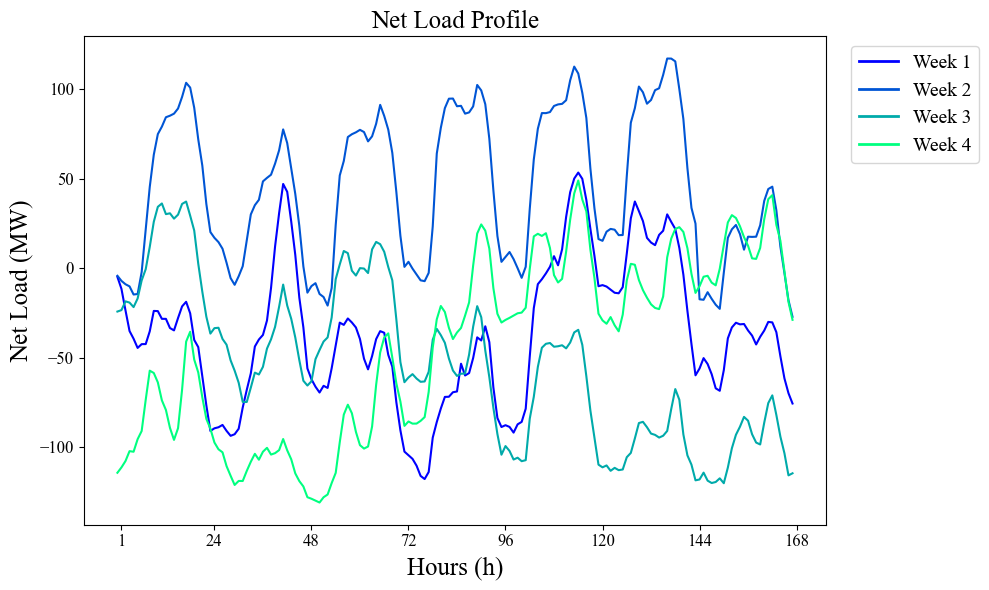

max_pnl[137, 2] = 117.2486488
uld[day=6, hour=0, 2] = 7.105427357601e-15
uld[day=6, hour=1, 2] = -3.5527136788005e-15
uld[day=6, hour=2, 2] = 3.5527136788005e-15
uld[day=6, hour=3, 2] = -3.5527136788005e-15
uld[day=6, hour=4, 2] = 3.5527136788005e-15
uld[day=6, hour=5, 2] = 7.105427357601e-15
uld[day=6, hour=6, 2] = 7.105427357601e-15
uld[day=6, hour=7, 2] = -7.105427357601e-15
uld[day=6, hour=8, 2] = -0.0
uld[day=6, hour=9, 2] = -0.0
uld[day=6, hour=10, 2] = -0.0
uld[day=6, hour=11, 2] = -0.0
uld[day=6, hour=12, 2] = -0.0
uld[day=6, hour=13, 2] = -0.0
uld[day=6, hour=14, 2] = -0.0
uld[day=6, hour=15, 2] = -0.0
uld[day=6, hour=16, 2] = -0.0
uld[day=6, hour=17, 2] = -0.0
uld[day=6, hour=18, 2] = -0.0
uld[day=6, hour=19, 2] = -0.0
uld[day=6, hour=20, 2] = 1.4210854715202e-14
uld[day=6, hour=21, 2] = -7.105427357601e-15
uld[day=6, hour=22, 2] = -0.0
uld[day=6, hour=23, 2] = -1.06581410364015e-14
uld[day=7, hour=0, 2] = -0.0
uld[day=7, hour=1, 2] = -7.105427357601e-15
uld[day=7, hour=2, 2]

KeyError: "Index '(0, np.int64(136), np.int64(1))' is not valid for indexed component 'pw'"

In [ ]:
# Initialize a 2D numpy array pnl with zeros to store net load values
# Dimensions: number of days (nd) x number of hours (nh)
pnl = np.zeros((nd,nh))

# Loop over every day and hour to compute net load for bus 2
for td in range(nd):
  for th in range(nh):
    # Net load = total demand at bus 2 minus total renewable generation at all renewable buses
    # pld[td, th, 2]: demand at bus 2 at time (td, th)
    # pr[td, th, w]: renewable generation at renewable bus w at time (td, th)
    pnl[td,th] = pld[td,th,2] - sum(pr[td,th,w] for w in m.w)

# Trim pnl to only the first 4 weeks (assuming 7 days per week)
# pnl[:4*7, :] selects the first 28 days of data
pnl_trimmed = pnl[:4 * 7, :]

# Reshape pnl_trimmed for plotting by weeks:
# - reshape to (4 weeks, 7 days, nh hours)
# - transpose to bring days and hours together and weeks last: shape becomes (7, nh, 4)
# - reshape to combine days and hours for x-axis: shape (nh*7, 4)
pnl = pnl_trimmed.reshape(4, 7, nh).transpose(1, 2, 0).reshape(nh*7, 4)

# Set up a colormap with number of colors equal to number of weeks (4)
colors = plt.cm.get_cmap('winter', pnl.shape[1])

plt.figure(figsize=(10, 6))
x = np.arange(len(pnl))

# Plot net load profile for each week
for i, week in enumerate(pnl.T):  # Transpose to loop over weeks
    plt.plot(x, week, label=f'Week {i+1}', color=colors(i))

# Custom legend
legend_lines = [Line2D([0], [0], color=colors(i), lw=2) for i in range(pnl.shape[1])]
legend_labels = [f'Week {i+1}' for i in range(pnl.shape[1])]
plt.legend(legend_lines, legend_labels, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)

# Axis ticks and labels
tick_positions = [1] + [24 * i for i in range(1, 8)]
tick_positions = [t for t in tick_positions if t <= 168]
plt.xticks(tick_positions, [str(t) for t in tick_positions], fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Hours (h)', fontname='Times New Roman', fontsize=18)
plt.ylabel('Net Load (MW)', fontname='Times New Roman', fontsize=18)
plt.title('Net Load Profile', fontname='Times New Roman', fontsize=18)
plt.tight_layout()
plt.show()

# Find the day (td) and hour (th) indices where pnl is maximum over all days and hours
max_td, max_th = np.unravel_index(np.argmax(pnl), pnl.shape)

# Print the maximum net load value and its location (add 1 for 1-based counting)
print(f"max_pnl[{max_td+1}, {max_th+1}] = {pnl[max_td, max_th]}")

td_list = list(m.td)  # List of day keys
th_list = list(m.th)  # List of hour keys
week2_day_keys = td_list[6:13]

# For node 2, print the load shedding at the max net load time
for td in week2_day_keys:
  for th in th_list:
    uld_val = m.uld[td, th, 2].value
    print(f"uld[day={td}, hour={th}, {2}] = {uld_val}")

# For each generator g in the model, print the generation at the max net load time
for g in m.g:
    for td in week2_day_keys:
        for th in th_list:
            pg_val = m.pg[g, td, th].value
            print(f"pg[{g}, day={td}, hour={th}] = {pg_val}")

# For each renewable bus w, print renewable generation at max net load time
for w_max in m.w:
    pw_max = m.pw[w_max,max_td,max_th].value
    print(f"pw_max[{w_max}, {max_td+1}, {max_th+1}] = {pw_max}")

# For each battery b, print charging power at max net load time
for cb_max in m.b:
    pcb_max = m.pcb[cb_max,max_td,max_th].value
    print(f"pcb_max[{cb_max}, {max_td+1}, {max_th+1}] = {pcb_max}")

# For each battery b, print discharging power at max net load time
for db_max in m.b:
    pdb_max = m.pdb[db_max,max_td,max_th].value
    print(f"pdb_max[{db_max}, {max_td+1}, {max_th+1}] = {pdb_max}")

# For each branch i to j, print the power flow at max net load time
for i_max in m.i:
  for j_max in m.j:
    pl_max = m.pl[i_max,j_max,max_td,max_th].value
    print(f"pl_max[{i_max}, {j_max}, {max_td+1}, {max_th+1}] = {pl_max}")
